#### Building a Simple Next Word Prediction Model

In [1]:
# Import all the packages
from datasets import load_dataset
import tensorflow as tf
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Input, Dropout, Bidirectional
import fasttext
import re
import os

/mnt/2d246428-d4b8-443d-a1ba-36fec24b2d5c/Project/capstone/Code/nxtword/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-08 16:16:48.082558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731062808.096815   42016 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731062808.101151   42016 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 16:16:48.115123: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use a

In [2]:
# Loading the Dataset
ds = load_dataset("agentlans/high-quality-english-sentences")
embed = fasttext.load_model('keyboard.bin')
count = 500

In [3]:
count=1000

In [4]:
DataFrame = pd.DataFrame(data=ds['train']['text'][:count],columns=['Text'])
print("Sample Text Information: ", DataFrame.iloc[0]['Text'])

Sample Text Information:  Soon we dropped into a living forest, where cold-tolerant evergreens and boreal animals still evoke the Canadian heritage of an ecosystem pushed south by glaciers 20,000 years ago.


In [5]:
DataFrame['Text'][0]

'Soon we dropped into a living forest, where cold-tolerant evergreens and boreal animals still evoke the Canadian heritage of an ecosystem pushed south by glaciers 20,000 years ago.'

In [6]:
max_length = 3  # Max sequence length

In [7]:
# This will generate all the Inputs and Outputs
vocab = set()
Data = {'X': [], 'Y' : []}
for i in DataFrame['Text']:
    info = re.sub(r'[!@#$%^&*()\-=_{}[\];:"\'<>,.?/|\\]', '', i)
    info = i.split(' ')
    for x in range(0,len(info)-max_length):
        Data['X'].append(" ".join(info[x:x+max_length]))
        Data['Y'].append(info[x+max_length])
        vocab = set.union(vocab, info[x:x+max_length+1])

In [8]:
vocab_size = vocab.__sizeof__() ## Vocab Size
# Pre-set Config
embedding_dim = 200

In [9]:
Data_embed = {'X':[], 'Y':[]}
for i in range(len(Data['X'])):
    Data_embed['X'].append(np.array([embed.get_word_vector(word)  for word in embed.get_line(Data['X'][i])[0]]))
    Data_embed['Y'].append(embed.get_sentence_vector(Data['Y'][i]).reshape(1, -1))
Data_embed['X'] = np.array(Data_embed['X'])
Data_embed['Y'] = np.array(Data_embed['Y'])

In [10]:
words = embed.get_words()
vocab_size = len(words)

In [11]:
model = Sequential()
model.add(Input(shape=(6, 200)))
model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
# model.add(Dense(45,activation='sigmoid'))
# model.add(Dense(30,activation='relu'))
# model.add(Dropout(rate=0.3))
# model.add(Dense(50,activation='relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(embedding_dim, activation='tanh'))

W0000 00:00:1731062828.014865   42016 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │        40,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 281,000 (1.07 MB)

 Trainable params: 281,000 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer='adagrad', loss='mse', metrics=['mae'])
history = model.fit(Data_embed['X'], Data_embed['Y'], epochs=100, batch_size=32)

Epoch 1/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0112 - mae: 0.0838
Epoch 2/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0107 - mae: 0.0821
Epoch 3/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0104 - mae: 0.0809
Epoch 4/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0101 - mae: 0.0795
Epoch 5/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0098 - mae: 0.0786
Epoch 6/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0095 - mae: 0.0774
Epoch 7/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0093 - mae: 0.0765
Epoch 8/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0092 - mae: 0.0758
Epoch 9/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0090 - mae: 0.0750
Epoch 10/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0088 - mae: 0.0744
Epoch 11/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0087 - mae: 0.0737
Epoch 12/100
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0086 - mae: 0.0732
Epoch 13/100


In [14]:
model.save("word.keras")

In [15]:
filesize = os.path.getsize('word.keras')
print(f"Model Size : {(filesize/1024):.2f} KB") 

Model Size : 2228.59 KB


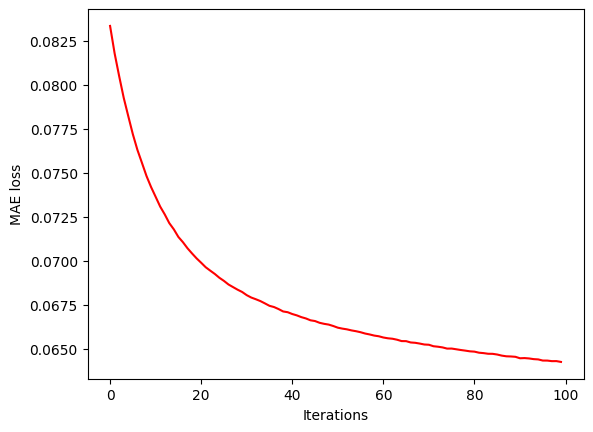

In [16]:
import matplotlib.pyplot as plt
plt.xlabel('Iterations')
plt.ylabel('MAE loss')
plt.plot(history.history['mae'], c='red')
plt.show()

In [17]:
# Inference

In [18]:
model = tf.keras.models.load_model('word.keras')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()
with open("quantized_model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpav3n_nl_/assets


INFO:tensorflow:Assets written to: /tmp/tmpav3n_nl_/assets


Saved artifact at '/tmp/tmpav3n_nl_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6, 200), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 200), dtype=tf.float32, name=None)
Captures:
  124422958372752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124422958371600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124422958372176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124423018712912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124423018715408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124423018717328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124422958375056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124422958376208: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1731063496.943718   42016 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1731063496.943728   42016 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-08 16:28:16.943856: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpav3n_nl_
2024-11-08 16:28:16.944534: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-08 16:28:16.944547: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpav3n_nl_
2024-11-08 16:28:16.951633: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-08 16:28:16.982006: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpav3n_nl_
2024-11-08 16:28:16.996109: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 52254 microseconds.
2024-11-08 16:28:17.097858: W tensorflow/comp

In [20]:
import json
store = open("model.json", "w")
# tf.keras.Model.
json.dump(tf.keras.Model.to_json(model), store)
store.close()

In [21]:
print(Data['X'][10])
print(Data['Y'][10]) 

and boreal animals
still


In [22]:
result = model.predict(Data_embed['X'][10].reshape(-1,4,200))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


In [23]:
result = result.reshape(-1,)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
words = embed.get_words()
word_vectors = np.array([embed.get_word_vector(word) for word in words])

In [25]:
cos_similarities = cosine_similarity([result], word_vectors)
top_3_indices = np.argsort(cos_similarities, axis=1)[0][::-1][:3]

In [26]:
top_3_words = [words[index] for index in top_3_indices]

In [27]:
top_3_words

['non-small', 'the', 'Brefney']